NOTE : currently you can not use this on your camputer , but for more information you can check the process i had pass

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm  

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [3]:
# Paths
gray_dir = r"C:\Users\Asus\Desktop\attemptes\dataset\all gray"
color_dir = r"C:\Users\Asus\Desktop\attemptes\dataset\all image"


In [4]:
# Dataset class
class ColorizationDataset(Dataset):
    def __init__(self, gray_dir, color_dir, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.transform = transform
        self.images = os.listdir(gray_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        gray_image = Image.open(os.path.join(self.gray_dir, self.images[idx])).convert("L")
        color_image = Image.open(os.path.join(self.color_dir, self.images[idx])).convert("RGB")

        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)

        return gray_image, color_image


In [5]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [6]:
# Load data
dataset = ColorizationDataset(gray_dir, color_dir, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [7]:
# U-Net model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def block(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = block(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        # Decoder
        dec3 = self.up3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.final(dec1))


In [8]:
# Initialize model
model = UNet().to(device)

In [9]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# TensorBoard logging
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experiment1')

In [11]:
# Training loop with tqdm for progress bar
num_epochs = 20
for epoch in range(num_epochs):
    torch.cuda.empty_cache()


In [12]:
import torch
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   30121 KB |   30121 KB |   30121 KB |       0 B  |
|       from large pool |   27392 KB |   27392 KB |   27392 KB |       0 B  |
|       from small pool |    2729 KB |    2729 KB |    2729 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |   30121 KB |   30121 KB |   30121 KB |       0 B  |
|       from large pool |   27392 KB |   27392 KB |   27392 KB |

In [ ]:
import os
import time

checkpoint_path = "checkpoint.pth"
last_checkpoint_time = time.time()
start_epoch = 0
start_batch = 0

# Resume if checkpoint exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    start_batch = checkpoint.get('batch', 0)
    print(f"Resuming training from epoch {start_epoch}, batch {start_batch}")
else:
    print("Starting training from scratch.") 

# Training loop with tqdm for progress bar
num_epochs = 1
for epoch in range(start_epoch, num_epochs):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch [{epoch+1}/{num_epochs}]', leave=True)

    for batch_idx, (gray_imgs, color_imgs) in progress_bar:
        # Skip already-trained batches
        if epoch == start_epoch and batch_idx < start_batch:
            continue

        gray_imgs = gray_imgs.to(device)
        color_imgs = color_imgs.to(device)

        outputs = model(gray_imgs)
        loss = criterion(outputs, color_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm
        progress_bar.set_postfix(loss=loss.item())

        # Save checkpoint every hour
        if time.time() - last_checkpoint_time > 600:
            torch.save({
                'epoch': epoch,
                'batch': batch_idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
            last_checkpoint_time = time.time()
            print(f"Checkpoint saved at epoch {epoch}, batch {batch_idx}")



    writer.add_scalar('Loss/train', running_loss / len(dataloader), epoch + 1)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

# Save final model and close writer
writer.close()
torch.save(model.state_dict(), 'colorization_unet.pth')
print("Training complete!")

# Visualization stays unchanged
def show_results(model, dataset):
    model.eval()
    gray_imgs, color_imgs = next(iter(DataLoader(dataset, batch_size=8)))
    with torch.no_grad():
        outputs = model(gray_imgs.to(device)).cpu()

    fig, axes = plt.subplots(4, 3, figsize=(10, 12))
    for i in range(4):
        axes[i, 0].imshow(gray_imgs[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Grayscale")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(transforms.ToPILImage()(color_imgs[i]))
        axes[i, 1].set_title("Original Color")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(transforms.ToPILImage()(outputs[i]))
        axes[i, 2].set_title("Predicted Color")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Show sample results
show_results(model, dataset)


Resuming training from epoch 0, batch 17212


Epoch [1/1]:  11%|█         | 1952/17490 [00:58<10:32, 24.55it/s]

In [14]:
import torch
from torchvision import transforms
from PIL import Image

# Load the model
model = UNet().to(device)
model.load_state_dict(torch.load(r"C:\Users\Asus\Desktop\attemptes\try2\colorization_unet.pth",map_location=torch.device('cpu')))
model.eval()
print("Model loaded successfully!")

    # Load and preprocess grayscale image
def load_and_preprocess_image(image_path):
    gray_image = Image.open(image_path).convert("L")
    gray_image = gray_image.resize((256, 256))

    transform = transforms.Compose([
        transforms.ToTensor(),  # No normalization
    ])

    gray_image = transform(gray_image)
    gray_image = gray_image.unsqueeze(0).to(device)
    return gray_image

def colorize_image(model, gray_image):
    with torch.no_grad():
        output = model(gray_image)
        output_image = output.squeeze(0).cpu()
        output_image = output_image.permute(1, 2, 0)
        output_image = output_image.clamp(0, 1)  # Ensure valid range

        output_image = Image.fromarray((output_image.numpy() * 255).astype('uint8'))
        return output_image





Model loaded successfully!


In [15]:
def show_images(original,gray_image, colorized):
    # Show original and colorized images side by side
    plt.figure(figsize=(15, 3))
    gray_image_display = gray_image.squeeze()
    
    plt.subplot(1, 3, 1)
    plt.title("Original Grayscale")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("gray scale")
    plt.imshow(gray_image_display, cmap='gray', vmin=0, vmax=1)

    plt.axis('off')

    plt.subplot(1,3, 3)
    plt.title("Colorized")
    plt.imshow(colorized)
    plt.axis('off')


    plt.show()



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

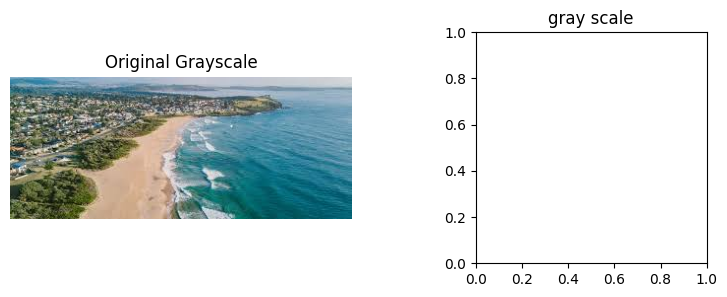

In [16]:
import tensorflow as tf
input_image = input("Enter image path or 'quit' to exit: ")
import cv2
while input_image != "quit":
    image_path = input_image[1:-1]

    # Load original image for display
    original_image = Image.open(image_path)


    # Preprocess image for model
    gray_image = load_and_preprocess_image(image_path)

    # Colorize image
    colorized_image = colorize_image(model, gray_image)
    
    # Show images
    show_images(original_image, gray_image, colorized_image)

    input_image = input("Enter image path or 'quit' to exit: ")

